# Time Series Analysis Use Case

## World Migration

December 19, 2022.

@author: Oscar A. Trevizo

This use case is one of a series of use cases on migration. It loads the *time series* DataFrame created in "use_case_world_migration_create_time_series.ipynb". It uses global demographics, economy, and migration data published by the United Nations and the World Bank. These data allow us to work on time series analysis. The objective is to identify patterns, exogenous variables, and trends related to migration.

Use Case: Pandas, Seaborn, time series DataFrame created in "use_case_world_migration_create_time_series.ipynb", ARIMA models

- Pandas: data format transformation, converting to datetime, setting index.
- Opbject Oriented (OO) time series.
- Seaborn lineplots.
- Matplotlib, histograms, q-q plots.
- train, test datasets and predictions.
- Statsmodels sts.seasonal_decompose
- ARIMA models.
- Auto Correlation Function (ACF) and Partial ACF (PACF).
- Augmented Dickey-Fuller (ADF) method to test stationary.



# Python Libraries and Functions

This section is located here to include all Python libraries and functions in one place before the actual wrangling and analytics code begins to better organize the scripts that follow.

### _Python Libraries_

In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import numpy as np
import numpy.random as nr
from math import log, sqrt
import seaborn as sns
from math import log, sqrt, sin
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import influence_plot, plot_regress_exog
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.tsa.seasonal as sts
from statsmodels.tsa.seasonal import STL
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from statsmodels.tsa.api import VAR
import statsmodels.graphics.tsaplots as splt
import pmdarima as pm
from pmdarima import model_selection
import warnings

%matplotlib inline


### _Python Functions_

In [2]:
##
#
# Functions
#
##


# A function to plot the time series stored in a DataFrame, column by column.
def lineplots_ts(df):
    """
    INPUTS: 
    df: DataFrame with numeric columns
    
    RETURNS: Nothing
    
    The plots aim to display time series in general.
    Each numeric column of the df is expected to be a time series.
    It plots each numeric column.
    """
    no_of_plots = df.shape[1]
    fig, ax = plt.subplots(df.shape[1], 1, figsize=(10, 2*no_of_plots))
    ax = ax.flatten()

    for i in range(df.shape[1]):
        if is_numeric_dtype(df[df.columns[i]]):
            sns.lineplot(x = df.index, y = df.columns[i], data = df, ax=ax[i])
            ax[i].axhline(y = df[df.columns[i]].mean(), color = 'r', linestyle = '-')



### _Python Object Oriented (OO)_

In [3]:
##
#
# Objected Oriented
#
##

class TimeSeries:
    def __init__(self, ts, train_size=0):
        """
        Class instantiates object that contains a time series.
        
        Parameters
        ----------
        ts: 2D array or DataFrame with index type datatime and one numeric columns.
        train_size: int, to create train and test sets.
        
        Returns
        -------
        tain, test: time series train and test
        """
        #your code here
        self.ts = ts
        self.train_size = train_size
        
        if train_size > 0:
            # needs from pmdarima import model_selection
            self.train, self.test = model_selection.train_test_split(self.ts, train_size=self.train_size)
            
    def lineplots_ts(self):
        """
        The plots aim to display time series in general.
        Each numeric column of the df is expected to be a time series.
        It plots each numeric column.
        """
        no_of_plots = self.ts.shape[1]
        fig, ax = plt.subplots(self.ts.shape[1], 1, figsize=(10, 2*no_of_plots))
        ax = ax.flatten()

        for i in range(self.ts.shape[1]):
            if is_numeric_dtype(self.ts[self.ts.columns[i]]):
                sns.lineplot(x = self.ts.index, y = self.ts.columns[i], data = self.ts, ax=ax[i])
                ax[i].axhline(y = self.ts[self.ts.columns[i]].mean(), color = 'r', linestyle = '-')

                    
    def plot_hist_qq(self, title='time series', bins=40):
        """
        Plots histogram and Q-Q to visualize distribution and Normality.
        
        Parameters
        ----------
        title: string with title for the histogram plot.
        bins: int with number of bins to plot the histogram.
        """
        # plot_hist_and_qq(sel.ts, title=title, bins=bins)
        
        _,ax = plt.subplots(1,2,figsize=(10,4))
        
        ## Plot the histogram with labels
        self.ts.hist(ax = ax[0], bins = bins, alpha = 0.5);
        ax[0].set_xlabel('Value');
        ax[0].set_ylabel('Frequency');
        ax[0].set_title('Histogram of ' + title);
        ## Plot the q-q plot on the other axes
        ss.probplot(self.ts, plot = ax[1]);

        
    def acf_pacf_plots(self):
        """
        Plots Auto Correlation Function (ACF) and Partial ACF (PACF).
        """
        lags = len(self.ts) // 3
        print('lags = ', lags)
        _,ax = plt.subplots(2,1, figsize=(8,8))
        _=splt.plot_acf(self.ts, lags = lags, ax=ax[0]);
        _=splt.plot_pacf(self.ts, lags = lags, method='yw', ax=ax[1]);
        
    def test_ADF_stationary(self):
        """
        Augmented Dickey-Fuller (ADF) method to test stationary.
        
        Returns:
        ADF_dict: dictionary with results. ADF static, p-value, lags, key_values
    
        p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
        p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
        https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
        https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf
        https://machinelearningmastery.com/time-series-data-stationary-python/
        https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html
        """
        stationary = adfuller(self.ts)
        ADF_dict = {'test_stat':stationary[0],
                    'p-value':stationary[1],
                    'lags':stationary[2],
                    't-value_10%_conf':stationary[4]['10%'],
                    't-value_5%_conf':stationary[4]['5%'],
                    't-value_1%_conf':stationary[4]['1%']
                   }

        ## Print the results
        print('ADF test statistic = ' + str(ADF_dict['test_stat']))
        print('p-value = ' + str(ADF_dict['p-value']))
        print('Critical Values:')
        # stationary[4] is a dictionary {'10%':float, 1%':float, '5%':float}
        for key, value in stationary[4].items():
            print('\t%s: %.3f' % (key, value))

        # To reject the H0 null hypothesis, the p-value needs to be < 0.05 (rule of thumb) and
        # the t-value at confidence interval 5% needs to be larger than the ADF test static (critical value)
        # Note that larger is not abs(), so more negative is smaller than less negative
        if (ADF_dict['p-value'] <= 0.05) & (ADF_dict['t-value_5%_conf'] > ADF_dict['test_stat']):
            print("*** Time series is stationary.")
            # The series does not have a unit root and it is stationary.
            print("*** Reject the null hypothesis (H0). Both p-value <= 0.05, and t-test 5% conf interval > test static.")
        else:
            print("*** Time series is non-stationary.")
            print("*** Failed to reject the null hypothesis (H0). Either p-value > 0.05, or t-test 5% conf interval < test static.")
    
        print('Number of lags used = ' + str(stationary[2]))
    
        return ADF_dict
    
    def decompose(self, extrapolate_trend='freq', period=12):
        """
        Decomposes the time series into residual, trend, and seasonal series, and plots them.
        
        Parameters
        ----------
        extrtapolate_trend: str, 
        period: int, number of periods, depending on time series. May be in days, month, years, etc.
        
        Returns:
        DataFrame: time series datetime index, columns 'resid', 'trend', 'seasonal'.
        """
        res = sts.seasonal_decompose(self.ts, extrapolate_trend = extrapolate_trend, period = period) 
        res.plot()
        return(pd.DataFrame({'resid': res.resid, 
                             'trend': res.trend, 
                             'seasonal': res.seasonal}, 
                            index = self.ts.index))

    def arima(self, exog=None, order=(0,0,0), seasonal_order=(0, 0, 0, 0), freq=None):
        """
        Return ARIMA model fit.

        Parameters
        ----------
        exog: array
        order: tuple with three components p, d, q
        seasons_order: tuple with four component P, D, Q, S
        freq: str, 'A-DEC' as example

        Returns: 
        ARIMA model fit()
        """

        model = ARIMA(self.ts, exog=exog, order=order, seasonal_order=seasonal_order, freq=freq)
        model_fit = model.fit()
        print('freq used = ', freq)
        print(model_fit.summary())
        return(model_fit)
       
    def auto_arima(self, exogenous, start_p=1, start_q=1, max_p=3, max_q=3, m=10,
               start_P=0, seasonal=True, d=1, D=1, trace=True, information_criterion = 'bic',
               stepwise=True):
        """
        Runs multiple ARIMA models and selects bets model.

        Parameters
        ----------
        exogenous: 2D array or DataFrame with index type datatime and one numeric columns.
        start_p: default 1 
        start_q: defaults 1 
        max_p: default 3
        max_q: default 3 
        m: int, number of periods <-- important
        start_P: default 0 
        seasonal: Logical True/Fals, default True 
        d: default 1
        D: default 1
        trace: logical True/False default True
        information_criterion: str, default 'bic'
        stepwis: Logical True/False default True

        Returns: 
        ARIMA model fit()
        """
        auto_model = pm.auto_arima(self.ts, exogenous=exogenous, start_p=start_p, start_q=start_q,
                                   max_p=max_p, max_q=max_q, m=m, start_P=start_P, seasonal=seasonal,
                                   d=d, D=D, trace=trace, information_criterion=information_criterion,
                                   stepwise=stepwise)
        return auto_model

    def test_markov_regime(self, exog=None, k_regimes=2, freq='Y'):
        """
        'Markov switching models in statsmodels to estimate dynamic regression models with changes in regime.'
        Calculates Markov regression probabilities of regine changes, plots the series, and returns the series.

        Parameters
        ----------
        endog: numeric series
        exog: numeric series
        k_regimes: int, number of regines
        freq: sdtr, 'Y' default

        Returns: 
        --------
        the model fit
        
        References:
        -----------
        https://www.statsmodels.org/stable/examples/notebooks/generated/markov_regression.html
        http://www.stata.com/manuals14/tsmswitch.pdf
        
        sm.tsa.MarkovRegression.__init__
        sm.tsa.MarkovRegression.__dict__

        """
        markov_regression_fit = sm.tsa.MarkovRegression(endog=self.ts, exog=exog, k_regimes=k_regimes, freq=freq).fit()
        markov_regression_probs = markov_regression_fit.smoothed_marginal_probabilities[1]
        markov_regression_probs.plot(title="Markov Regression Regime Test")
        
        return markov_regression_fit

    def get_train_test(self):
        """
        Obtain train and test samples from the list
         
        Parameter:
        ----------
        train_size: int
        
        Returns:
        --------
        train, test lists
        """
        
        train = self.train
        test = self.test
    
        return train, test

    def predict(self, train_exog=None, test_exog=None, trace=True, m=5, time_start=1960):
        """
        Predict and plot based on auto_arima model and on a train/test splif of the time series
        
        Parameters:
        -----------
        train: time series
        test: time series
        train_exog: time series
        test_exog: time series
        
        Returns:
        --------
        preds, conf_int: predictions and confidence intervals
        """
        
        train = self.train
        test = self.test
    
        mod_auto_arima = pm.auto_arima(train, exogenous=train_exog, start_p=1, start_q=1, start_P=1, start_Q=1,
                         max_p=3, max_q=3, max_P=3, max_Q=5, seasonal=True, trace=trace, m=m,
                         information_criterion = 'bic', stepwise=True, suppress_warnings=True, D=1,
                         error_action='ignore')

        # The script is based on example provided by alkaline-ml.com:
        # http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html
        # http://alkaline-ml.com/pmdarima/1.0.0/auto_examples/arima/example_auto_arima.html#sphx-glr-auto-examples-arima-example-auto-arima-py
        # Additional reference:
        # https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

        preds, conf_int = mod_auto_arima.predict(n_periods=test.shape[0], exogenous=test_exog, return_conf_int=True)

        # Print the error:
        print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

        return preds, conf_int

    def predict_plot(self, preds, conf_int, time_start=1960, title='Forecasts', xlabel='Year'):
        """
        Predict and plot based on auto_arima model.
        
        Parameters:
        -----------
        train: time series
        test: time series
        preds: time series, predictons
        test_exog: time series
        
        Returns:
        --------
        None
        """

        train = self.train
        test = self.test
        
        # This script is based and takes code from the example provided in:
        # http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html
        # http://alkaline-ml.com/pmdarima/1.0.0/auto_examples/arima/example_auto_arima.html#sphx-glr-auto-examples-arima-example-auto-arima-py
        
        # Plot the points and the forecasts
        x_axis = np.arange(train.shape[0] + preds.shape[0])
        x_years = x_axis + time_start  # For example, year starts at 1960

        plt.plot(x_years[x_axis[:train.shape[0]]], train, alpha=0.75)
        plt.plot(x_years[x_axis[train.shape[0]:]], preds, alpha=0.75)  # Forecasts
        plt.scatter(x_years[x_axis[train.shape[0]:]], test, alpha=0.4, marker='x')  # Test data
        plt.fill_between(x_years[x_axis[-preds.shape[0]:]], conf_int[:, 0], conf_int[:, 1], alpha=0.1, color='b')
        plt.title(title)
        plt.xlabel(xlabel)
        
        return None


# Worldwide Migration View


## Data Sources: United Nations and World Bank

The United Nations publishes demographics and economics data that includes data on migration, country-by-country and region by region. 

The World Bank provides additional economics data, including GDP growth per country, per region and worldide that can be used as exogenous variables in time series analysis of migration.

### _United Nations World Population Prospects_

The United Nations World Population Prospects dataset gives us insights from net migration and migration rates, to explore trends over time. The data is suitable to generate time series, visualization, and serial correlation. The time series analysis considers time periods that may be characterized by world events or regime changes. We will explore possible cycles.

The dataset provides records for a specific country or from a group of countries with various classifications. In the dataset provided by the UN, the group of countries labeled under 'Central America' includes Mexico. Normally Mexico is under North America. Here, the UN classified Mexico under Central America. To avoid confusion with the classic geographic classification for North America (North America includes Mexico, the US, and Canada), the report used the word 'Northern' instead 'North' in 'Northern America' to include only Canada and the US under 'Northern America'.

https://population.un.org/wpp/Download/SpecialAggregates/EconomicTrading/
http://data.un.org/_Docs/SYB/CSV/SYB65_230_202209_GDP%20and%20GDP%20Per%20Capita.csv

#### _Load the data_

In [4]:
##
#
# Load data/normalized_world_migration_and_gdp.csv
#
# CSV created in Use Case 'use_case_world_migration_create_time_series.ipynb'
#
# Original sources accessed in November 2022.
#
# United Nations:
# UN datamart http://data.un.org/ 
# https://population.un.org/wpp/Download/Standard/MostUsed/
# https://population.un.org/wpp/Download/SpecialAggregates/EconomicTrading/
# File GEN/01/REV1: 
# Demographic indicators by region, subregion and country, annually for 1950-2100
# https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/\
# EXCEL_FILES/1_General/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_REV1.xlsx
#
# World Bank - World Development Indicators:
# GDP in current $USD:
# https://data.worldbank.org/indicator/NY.GDP.MKTP.KD?end=2021&start=1961&view=chart
# GDP growth:
# https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?end=2021&start=1961&view=chart
# GDP per capita growth (constant 2015 US$):
# https://data.worldbank.org/indicator/NY.GDP.PCAP.KD.ZG?end=2021&start=1960&view=chart
# Inflation:
# https://data.worldbank.org/indicator/NY.GDP.DEFL.KD.ZG?end=2021&start=1960&view=chart
#
## 

# Normalized migraiton and GDP data
#
n_migr_gdp_df = pd.read_csv('../data/normalized_world_migration_and_gdp.csv')

#### _Set index to 'Year' for the time series_

In [5]:
n_migr_gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    61 non-null     object 
 1   N_EmigrationRate        61 non-null     float64
 2   N_ImmigrationRate       61 non-null     float64
 3   N_NetEmigration         61 non-null     float64
 4   N_NetImmigration        61 non-null     float64
 5   N_EmigrationGDPgrowth   61 non-null     float64
 6   N_ImmigrationGDPgrowth  61 non-null     float64
 7   N_EmigrationLogGDP      61 non-null     float64
 8   N_ImmigrationLogGDP     61 non-null     float64
 9   N_EmigrationPop         61 non-null     float64
 10  N_ImmigrationPop        61 non-null     float64
 11  N_PopulationTot         61 non-null     float64
 12  N_logGDP                61 non-null     float64
 13  N_GDP_growth_pct        61 non-null     float64
dtypes: float64(13), object(1)
memory usage: 6.8+

In [6]:
n_migr_gdp_df.Year = pd.to_datetime(n_migr_gdp_df['Year'], infer_datetime_format=True)
n_migr_gdp_df.set_index('Year', inplace=True)

n_migr_gdp_df.head()

,N_EmigrationRate,N_ImmigrationRate,N_NetEmigration,N_NetImmigration,N_EmigrationGDPgrowth,N_ImmigrationGDPgrowth,N_EmigrationLogGDP,N_ImmigrationLogGDP,N_EmigrationPop,N_ImmigrationPop,N_PopulationTot,N_logGDP,N_GDP_growth_pct
Year,,,,,,,,,,,,,
1960-12-31,-0.007903,0.007397,-0.002075,0.002953,0.005330,0.004550,0.011868,0.012488,0.001933,0.002812,0.002283,0.012114,0.005020
1961-12-31,-0.008085,0.008940,-0.002290,0.003299,0.008008,0.007989,0.011913,0.012408,0.002028,0.002754,0.002317,0.012110,0.008000
1962-12-31,-0.008761,0.008277,-0.002446,0.003148,0.010106,0.010967,0.011872,0.012474,0.002110,0.002691,0.002359,0.012130,0.010475
1963-12-31,-0.008716,0.008448,-0.002469,0.003310,0.012652,0.010230,0.011899,0.012546,0.002011,0.002964,0.002410,0.012170,0.011638
1964-12-31,-0.008794,0.008293,-0.002411,0.003273,0.013423,0.014147,0.011928,0.012623,0.002051,0.003034,0.002463,0.012219,0.013726


#### _Size of train data set_

This study includes time series predictions of forecasts. The purpose for setting the train set size here is to have some consistency during the application of the prediction methods. We still have the flexibility to hard coded down stream if necessary.

In [7]:
# Given the size of the dataset and the pupose for forecasting:
train_size = 50

#### _Verify New DataFrame PairGrid / Correlations: Emigration vs Immigration Granularity_

We have a transformed dataset that needs to be checked again.

#### _Plot the Time Series: Immigration, Emigration, and GDP_

Normalized World Wide Time Series




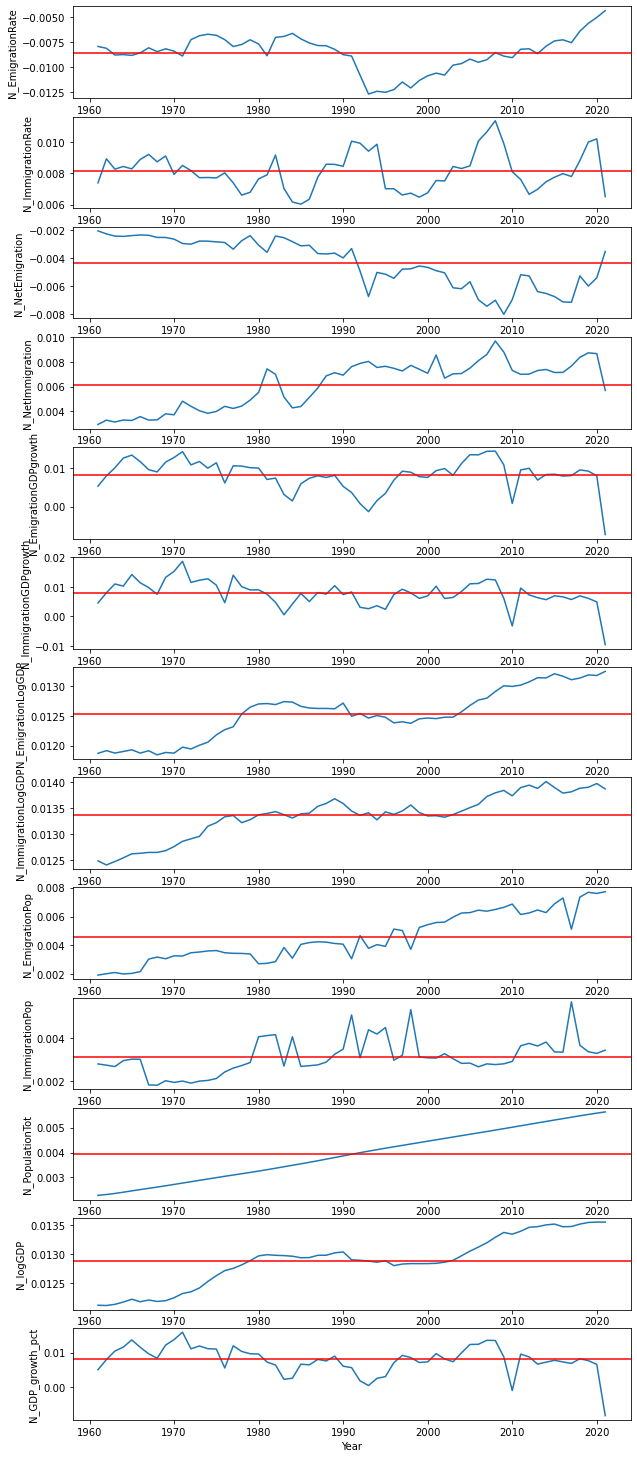

In [8]:
print('Normalized World Wide Time Series\n\n')
lineplots_ts(n_migr_gdp_df)

#### _Takeaways from worldwide time series (Normalized means)_

As with the previous approach, these plots distinguish countries with positive migration versus countries with negative migration.

We concur with the conclusions drawn from the previous sections in a different way:

> - Countries receiving migrants and countries sending migrants **mirror each other's migration trends**. 
>
> - Net migration (immigration and migration) has trends following population grows. Notice how the mean splits those lines depending on the trendline. 
>
> - There is a **significant outlier in trends** during the **Covid-19 years (2020)**. Covid-19 caused unprecedented migration behaviors.
>
> - The Immigration and emigration population reflect the population of the countries with positive versus negative migration on a year-by-year basis. 
>
> - The time series observe **stochastic trend.** There are many factors contributing to those stochastic movements. There are a few cases where a country experiences a revere migration (e.g., when normally a country has emigration, there are times when the country experience actually immigration, not often). Normally a country consistently experiences either emigration or immigration consistently, but it is not always consistent.
>
> - Therefore, this data is stochastic and **out of balance.** We can explore analysis and identify insights: We can tell GDP is a force that impact migration; we can tell that those countries with a faster population growth tend to experience emigration vs countries with slow population growth that tend to experience more immigration (more people coming in there).

Next in this study, I will further explore migration versus GDP, and will apply time series analysis to understand the behavior of migration country to country.

## Time Series Analysis Worldwide View

These next section will explor **Seasonal, Trend and Residual (STL)** models, consisting of:

- Trend removals with a LOESS regression model. 
- Seasonal component removals using regression on periodic components.
- Leaving a remainder known as the Residual. 

This study applies an **additive** approach, $TS(t) = S(t) + T(t) + R(t)$.

Reference: https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html


Important parameters:
- **p** Auto Regressive (AR) order.
- **d** number of differences.
- **q** order of Moving Average (MA).
- **P** seasonal AR term order. Autoregressive component with period **M**.  
- **D** order of differencing for non-stationary behavior. 
- **Q** seasonal MA term order. Mving average component with period **M**. 
- **S** period length.


### _TimeSeries Class: Pyuthon Object Oriented (OO)_

These section are based on a class called *TimeSeries* (see introductory section at the beginning of this study). Instantiating *TimeSeries* will facilitate *Exploratory Data Analysis* in this study (cleaner easier to follow and manage code).

In [9]:
# Tips from class and from https://stackoverflow.com/questions/1911281/how-do-i-get-list-of-methods-in-a-python-class
# TimeSeries.__dict__

### _Exogenous Variable_

An exogenous variable will add value to our models. An exogenous variable can improve how the models run regressions or other tests. The exogenous variable format depends on the method we apply. Here I will be focusing on *auto_arima()*. 

This script provides an Exploratory Data Analysys for the potential exogenous variable and creates a time series based on the format required by *auto_arima()*.

#### _log GDP_

##### _Instantiate TimeSeries object_

In [10]:
ww_logGDP = TimeSeries(n_migr_gdp_df.N_ImmigrationLogGDP, train_size=train_size)

##### _Plot histogram and Q-Q_

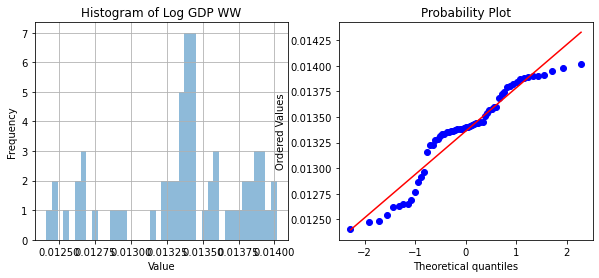

In [11]:
## OO method TimeSeries.plot_hist_qq
ww_logGDP.plot_hist_qq('Log GDP WW')

##### _Plot ACF and PACF_

lags =  20


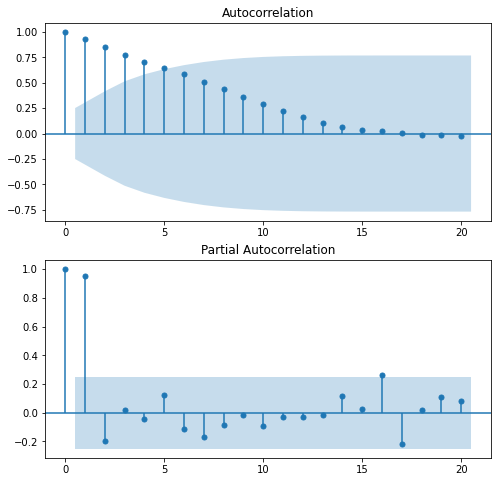

In [12]:
ww_logGDP.acf_pacf_plots()

##### _ADF stationary test_

In [13]:
ww_logGDP.test_ADF_stationary()

ADF test statistic = -1.7018939192586457
p-value = 0.4301369378219136
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
*** Time series is non-stationary.
*** Failed to reject the null hypothesis (H0). Either p-value > 0.05, or t-test 5% conf interval < test static.
Number of lags used = 0


{'test_stat': -1.7018939192586457,
 'p-value': 0.4301369378219136,
 'lags': 0,
 't-value_10%_conf': -2.5931902777777776,
 't-value_5%_conf': -2.9110731481481484,
 't-value_1%_conf': -3.5443688564814813}

##### _Histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q show that this is **not a Normal distribution.**
> - The time series is **non-stationary.**
> - It looks like a **Random Walk.** 
> - The **ACF** has a very **slow decay**, but it eventually reaches zero.
> - While the **confidence intervals** of the ACF increase, they tend to become stable.
> - The PACF exhibits **correlation** in observation 1 (adjacent to zero).
> - The PACF appears to show **some cycle** at lag 16 or 17. That is something to consider while modeling.

##### _Decompose the time series_

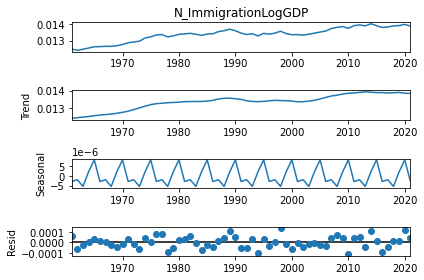

In [14]:
# Make period based on observation from decomposed residual (tested 20, 17*, 15, 10, 5 year periods)
decomp_ww_logGDP = ww_logGDP.decompose(extrapolate_trend='freq', period=5)

##### _Instantiate residuals object_

In [15]:
ww_logGDP_res = TimeSeries(decomp_ww_logGDP.resid)

##### _Plot residuals histogram and Q-Q_

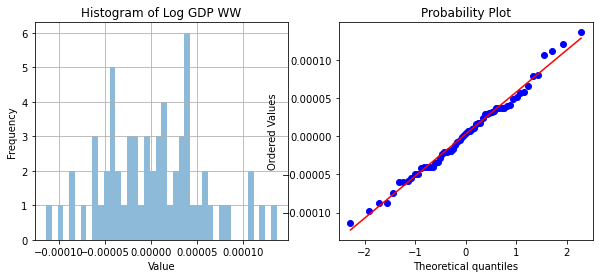

In [16]:
## OO method TimeSeries.plot_hist_qq
ww_logGDP_res.plot_hist_qq('Log GDP WW')

##### _Plot residuals ACF and PACF_

lags =  20


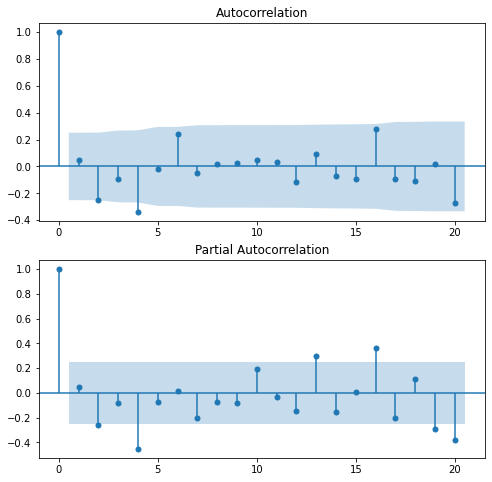

In [17]:
ww_logGDP_res.acf_pacf_plots()

##### _Residuals ADF stationary test_

In [18]:
ww_logGDP_res.test_ADF_stationary()

ADF test statistic = -6.944149953034168
p-value = 1.0072649300116634e-09
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
*** Time series is stationary.
*** Reject the null hypothesis (H0). Both p-value <= 0.05, and t-test 5% conf interval > test static.
Number of lags used = 3


{'test_stat': -6.944149953034168,
 'p-value': 1.0072649300116634e-09,
 'lags': 3,
 't-value_10%_conf': -2.5946240473991997,
 't-value_5%_conf': -2.913766394626147,
 't-value_1%_conf': -3.5506699942762414}

##### _Residuals histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q show **Normal distribution** characteristics.
> - The time series is **stationary.**
> - The time series looks could be **white noise**.
> - The **ACF** decays rapidly.
> - The ACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The ACT **confidence intervals** tend to become stable.
> - The PACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The PACF appears to be **periodical** or it may be **random**.

##### _Auto ARIMA residuals_

Apply the *auto_arima()* to the residual **stationary** model. Use an exogenous series on the auto_arima() model.

In [19]:
##
# BIC tests
#
# http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html
# https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

ww_logGDP_res_best_model = ww_logGDP_res.auto_arima(exogenous=None, start_p=1, start_q=1, max_p=3, max_q=3, m=5,
                       start_P=0, seasonal=True, d=1, D=1, trace=True, 
                       information_criterion = 'bic', stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,1)[5]             : BIC=-862.948, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[5]             : BIC=-849.175, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[5]             : BIC=-863.032, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[5]             : BIC=-868.455, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[5]             : BIC=-858.930, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[5]             : BIC=-862.686, Time=0.31 sec
 ARIMA(0,1,1)(0,1,2)[5]             : BIC=-865.675, Time=0.59 sec
 ARIMA(0,1,1)(1,1,0)[5]             : BIC=-869.516, Time=0.26 sec
 ARIMA(0,1,1)(2,1,0)[5]             : BIC=-867.444, Time=0.39 sec
 ARIMA(0,1,1)(2,1,1)[5]             : BIC=-860.153, Time=0.36 sec
 ARIMA(0,1,0)(1,1,0)[5]             : BIC=-857.745, Time=0.19 sec
 ARIMA(1,1,1)(1,1,0)[5]             : BIC=-864.488, Time=0.39 sec
 ARIMA(0,1,2)(1,1,0)[5]             : BIC=-870.336, Time=0.15 sec
 ARIMA(0,1,2)(0,1,0)[5]             : BIC=-861.363, Time=0.15 sec
 ARIMA(0,1,2)(2,1,0)[5]          

In [20]:
ww_logGDP_res_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   61
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 5)   Log Likelihood                 443.342
Date:                             Fri, 23 Dec 2022   AIC                           -878.685
Time:                                     15:46:04   BIC                           -870.655
Sample:                                          0   HQIC                          -875.580
                                              - 61                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5333   5.09e-18  -1.05e+17      0.000      -0.533      -0.533
ma.L2         -0.1717   2.79e-18  -6.16e+16      0.000      -0.172      -0.172
ma.S.L5       -0.3763   5.93e-18  -6.35e+16      0.000      -0.376      -0.376
sigma2      5.736e-09   1.41e-09      4.075      0.000    2.98e-09     8.5e-09
===================================================================================
Ljung-Box (L1) (Q):                   1.52   Jarque-Bera (JB):                 0.52
Prob(Q):                              0.22   Prob(JB):                         0.77
Heteroskedasticity (H):               2.45   Skew:                            -0.05
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.82e+33. Standard errors may be unstable.
"""

##### _Create the exog 2D array (DataFrame one column)_

In [21]:
# Generate exogenous series (index time series, column with the exog data)

# Stationary
exog_ww_st_logGDP = pd.DataFrame(decomp_ww_logGDP.resid)

# Not stationary
exog_ww_logGDP = pd.DataFrame(n_migr_gdp_df.N_ImmigrationLogGDP)

# train, test sets
train_ww_logGDP, test_ww_logGDP = ww_logGDP.get_train_test()

# Train exog
train_exog_ww_logGDP = pd.DataFrame(train_ww_logGDP)
print(train_exog_ww_logGDP.shape)
# Test exog
test_exog_ww_logGDP = pd.DataFrame(test_ww_logGDP)
print(test_exog_ww_logGDP.shape)

(50, 1)
(11, 1)


##### _Takeaways from SARIMAX Log GDP Worldwide_

> **Residuals:**
> - SARIMAX model order p, d, q, and seasonal P, D, Q, S (0, 1, 2) (0, 1, 1, 5).
> - *p* 0 indicatates there is no autocorrelation.
> - *d* 1 is low given that this is a stationary series.
> - *q* 2 is Moving Average order 2.
> - *P* 0 seasonal autocorrelation.
> - *D* 1 also low given this is stationary.
> - *Q* 1 seasonal Moving Average.
> - It was syuprisingly Moving Average.

### _ARMA Emigration Rates Worldwide_

#### _ARMA Before Decomposing: Emigration Rates Worldwide_

##### _Instantiate TimeSeries object_

In [22]:
ww_em_rate = TimeSeries(n_migr_gdp_df.N_EmigrationRate, train_size=train_size)

##### _Plot histogram and Q-Q_

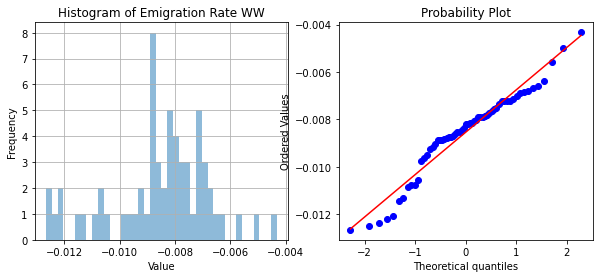

In [23]:
## OO method TimeSeries.plot_hist_qq
ww_em_rate.plot_hist_qq('Emigration Rate WW')

##### _Plot ACF and PACF_

lags =  20


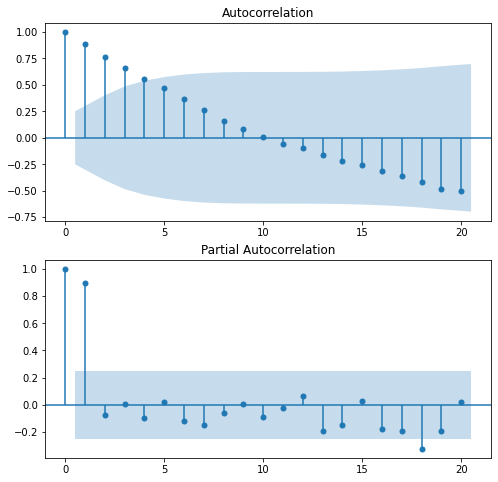

In [24]:
ww_em_rate.acf_pacf_plots()

##### _ADF stationary test_

In [25]:
ww_em_rate.test_ADF_stationary()

ADF test statistic = -0.510888746067146
p-value = 0.8898740579832798
Critical Values:
	1%: -3.544
	5%: -2.911
	10%: -2.593
*** Time series is non-stationary.
*** Failed to reject the null hypothesis (H0). Either p-value > 0.05, or t-test 5% conf interval < test static.
Number of lags used = 0


{'test_stat': -0.510888746067146,
 'p-value': 0.8898740579832798,
 'lags': 0,
 't-value_10%_conf': -2.5931902777777776,
 't-value_5%_conf': -2.9110731481481484,
 't-value_1%_conf': -3.5443688564814813}

##### _Histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q show that this is **not a good Normal distribution.** It may have a tendency to be Normal.
> - The time series is **non-stationary.**
> - It looks like a **Random Walk.** 
> - The **ACF** has a very **slow decay**, and it keeps on moving negatively.
> - The **confidence intervals** of the ACF increase. They tend to become stable, but not well. There is still a movement even in the end increasing confidence intervals.
> - The PACF exhibits **correlation** in observation 1 (adjacent to zero).
> - The PACF appears to show **some cycle** at lag 16 or 17. That is something to consider while modeling.

##### _Decompose the time series_

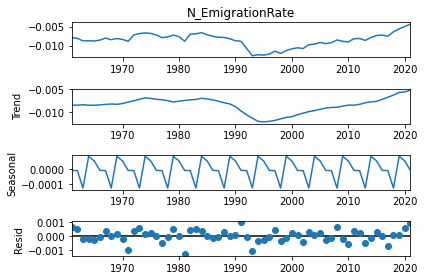

In [26]:
# Make period based on observation from decomposed residual (tested 20, 17*, 15, 10, 5 year periods)
decomp_ww_em_rate = ww_em_rate.decompose(extrapolate_trend='freq', period=5)

##### _Instantiate residuals object_

In [27]:
ww_em_rate_res = TimeSeries(decomp_ww_em_rate.resid)

##### _Plot residuals histogram and Q-Q_

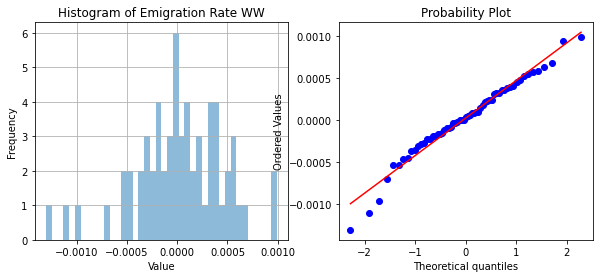

In [28]:
## OO method TimeSeries.plot_hist_qq
ww_em_rate_res.plot_hist_qq('Emigration Rate WW')

##### _Plot residuals ACF and PACF_

lags =  20


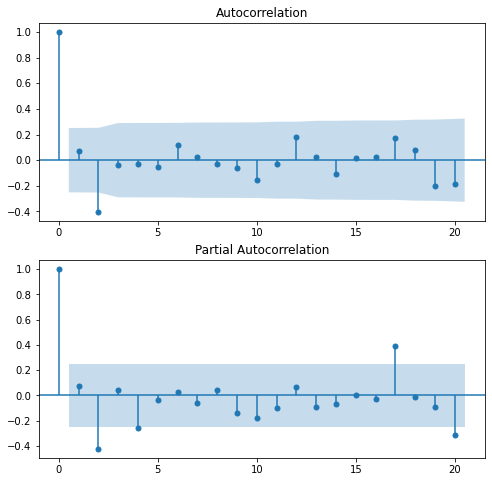

In [29]:
ww_em_rate_res.acf_pacf_plots()

##### _Residuals ADF stationary test_

In [30]:
ww_em_rate_res.test_ADF_stationary()

ADF test statistic = -8.070740677945171
p-value = 1.5520447906984967e-12
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
*** Time series is stationary.
*** Reject the null hypothesis (H0). Both p-value <= 0.05, and t-test 5% conf interval > test static.
Number of lags used = 1


{'test_stat': -8.070740677945171,
 'p-value': 1.5520447906984967e-12,
 'lags': 1,
 't-value_10%_conf': -2.5936515282964665,
 't-value_5%_conf': -2.911939409384601,
 't-value_1%_conf': -3.5463945337644063}

##### _Residuals histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q show **Normal distribution** characteristics.
> - The time series is **stationary.**
> - The time series looks could be **white noise**.
> - The **ACF** decays rapidly.
> - The ACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The ACT **confidence intervals** tend to become stable.
> - The PACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The PACF appears to be **periodical** or it may be **random**.

##### _Auto ARIMA residuals_

Apply the *auto_arima()* to the residual **stationary** model. Use an exogenous series on the auto_arima() model.

In [31]:
# BIC tests
#
# http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html
# https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

ww_em_rate_res_best_model = ww_em_rate_res.auto_arima(exogenous=exog_ww_st_logGDP, start_p=1, start_q=1, max_p=3, max_q=3, m=5,
                       start_P=0, seasonal=True, d=1, D=1, trace=True, 
                       information_criterion = 'bic', stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,1)[5]             : BIC=-640.972, Time=0.45 sec
 ARIMA(0,1,0)(0,1,0)[5]             : BIC=-607.052, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[5]             : BIC=-615.495, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[5]             : BIC=-645.224, Time=0.42 sec
 ARIMA(0,1,1)(0,1,0)[5]             : BIC=-627.778, Time=0.23 sec
 ARIMA(0,1,1)(1,1,1)[5]             : BIC=-636.564, Time=0.31 sec
 ARIMA(0,1,1)(0,1,2)[5]             : BIC=-639.634, Time=0.46 sec
 ARIMA(0,1,1)(1,1,0)[5]             : BIC=-632.028, Time=0.33 sec
 ARIMA(0,1,1)(1,1,2)[5]             : BIC=-633.724, Time=0.58 sec
 ARIMA(0,1,0)(0,1,1)[5]             : BIC=-631.509, Time=0.13 sec
 ARIMA(0,1,2)(0,1,1)[5]             : BIC=-623.494, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[5]             : BIC=-630.179, Time=0.37 sec
 ARIMA(1,1,2)(0,1,1)[5]             : BIC=-620.158, Time=0.51 sec
 ARIMA(0,1,1)(0,1,1)[5] intercept   : BIC=-641.829, Time=0.30 sec

Best model:  ARIMA(0,1,1)(0,1,1)

In [32]:
ww_em_rate_res_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 5)   Log Likelihood                 330.627
Date:                           Fri, 23 Dec 2022   AIC                           -653.253
Time:                                   15:46:12   BIC                           -645.224
Sample:                               12-31-1960   HQIC                          -650.148
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid          0.9427      1.281      0.736      0.462      -1.568       3.454
ma.L1         -0.6558      0.209     -3.139      0.002      -1.065      -0.246
ma.S.L5       -0.9066      0.307     -2.953      0.003      -1.508      -0.305
sigma2      2.977e-07   9.82e-08      3.031      0.002    1.05e-07     4.9e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.57
Prob(Q):                              0.90   Prob(JB):                         0.17
Heteroskedasticity (H):               0.60   Skew:                            -0.56
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### _Predict with auto_arima()_

Apply simple *auto_arima()* on the original dataset to visualize predictions. It uses the original dataset instead of the residuals to visualize the original pattern. 

Test RMSE: 0.002


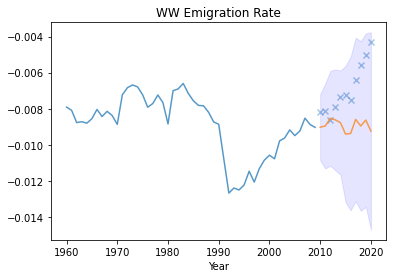

In [33]:
train_exog = train_exog_ww_logGDP
test_exog = test_exog_ww_logGDP
title = 'WW Emigration Rate'

# Based on the instantied time series, where the train and test sets came from.
preds, conf_int = ww_em_rate.predict(train_exog, test_exog, trace=False)
ww_em_rate.predict_plot(preds, conf_int, title=title)

##### _Markov Regression Regime Test_

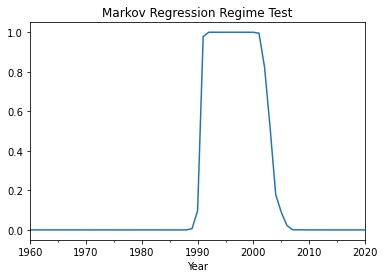

In [34]:
# exog=None, k_regimes=2, freq='Y'
ww_em_rate_markov = ww_em_rate.test_markov_regime()

##### _Takeaways from ARMA Emigration Rates Worldwide_

>
> **Residuals:**
> - SARIMAX model order p, d, q, and seasonal P, D, Q, S (0, 1, 1) (0, 1, 1, 5).
> - *p* 0 indicatates there is no autocorrelation.
> - *d* 1 is low given that this is a stationary series.
> - *q* 1 is Moving Average order 2.
> - *P* 0 seasonal autocorrelation.
> - *D* 1 also low given this is stationary.
> - *Q* 1 seasonal Moving Average.
> - It was syuprisingly Moving Average.
>
> **Markov Regression:**
> - We see a big movement in the 1990s: **Globalization.*
> - The big emmigration events worldwide in the 1990s: 
> - The fall of the **Berlin Wall and China Tiananmem Square, authocratic governments losing power**.
>
> **Forecast on original series:**
> - The forecast underestimated the reduction in emigration (less negative).
> - The test data is within the 95% confidence intervals.

### _ARMA Immigration Rates Worldwide_

#### _ARMA Before Decomposing: Immigration Rates Worldwide_

##### _Instantiate TimeSeries object_

In [35]:
ww_im_rate = TimeSeries(n_migr_gdp_df.N_ImmigrationRate, train_size=train_size)

##### _Plot histogram and Q-Q_

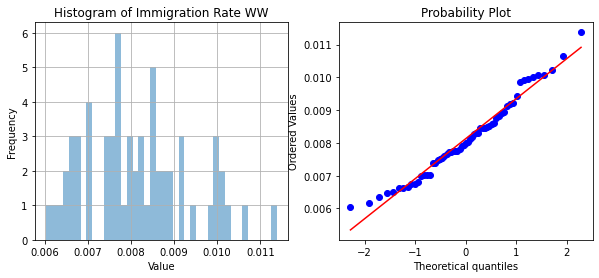

In [36]:
## OO method TimeSeries.plot_hist_qq
ww_im_rate.plot_hist_qq('Immigration Rate WW')

##### _Plot ACF and PACF_

lags =  20


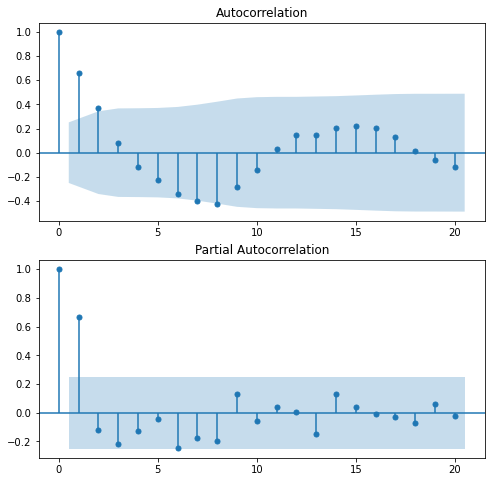

In [37]:
ww_im_rate.acf_pacf_plots()

##### _ADF stationary test_

In [38]:
ww_im_rate.test_ADF_stationary()

ADF test statistic = -3.6794243933999637
p-value = 0.004412055111768159
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
*** Time series is stationary.
*** Reject the null hypothesis (H0). Both p-value <= 0.05, and t-test 5% conf interval > test static.
Number of lags used = 1


{'test_stat': -3.6794243933999637,
 'p-value': 0.004412055111768159,
 'lags': 1,
 't-value_10%_conf': -2.5936515282964665,
 't-value_5%_conf': -2.911939409384601,
 't-value_1%_conf': -3.5463945337644063}

##### _Histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q show that this is **may be Normal distribution.** It has a tendency to be Normal.
> - The time series is **stationary.**
> - The time series is **periodical.** It is **not random**.
> - The **ACF** is **periodical**.
> - The **confidence intervals** of the ACF decrease. They tend to become stable.
> - The PACF exhibits **correlation** in observation 1 (adjacent to zero).
> - The PACF appears to show **cycles**.

##### _Decompose the time series_

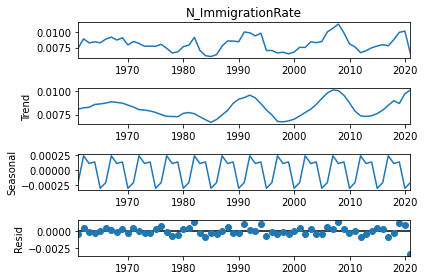

In [39]:
# Make period based on observation from decomposed residual (tested 20, 17*, 15, 10, 5 year periods)
decomp_ww_im_rate = ww_im_rate.decompose(extrapolate_trend='freq', period=5)

##### _Instantiate residuals object_

In [40]:
ww_im_rate_res = TimeSeries(decomp_ww_im_rate.resid)

##### _Plot residuals histogram and Q-Q_

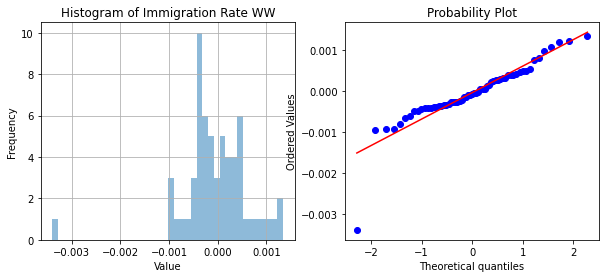

In [41]:
## OO method TimeSeries.plot_hist_qq
ww_im_rate_res.plot_hist_qq('Immigration Rate WW')

Notice the significant outlier. That is due to Covid-19. I ran experiments excluding 2020 and that outlier disappeared. It is best to keep it as a test to our modeling technniques.

##### _Plot residuals ACF and PACF_

lags =  20


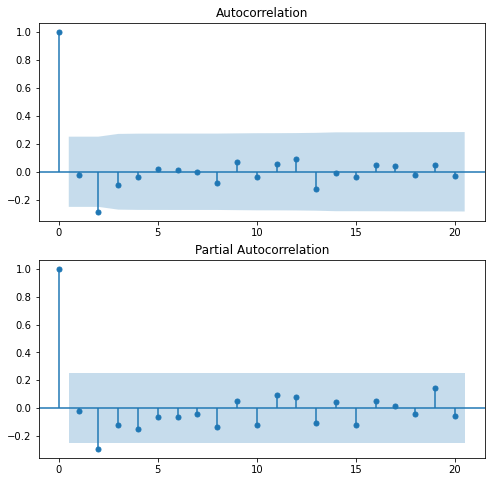

In [42]:
ww_im_rate_res.acf_pacf_plots()

##### _Residuals ADF stationary test_

In [43]:
ww_im_rate_res.test_ADF_stationary()

ADF test statistic = -6.82603420610545
p-value = 1.946859099006604e-09
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
*** Time series is stationary.
*** Reject the null hypothesis (H0). Both p-value <= 0.05, and t-test 5% conf interval > test static.
Number of lags used = 1


{'test_stat': -6.82603420610545,
 'p-value': 1.946859099006604e-09,
 'lags': 1,
 't-value_10%_conf': -2.5936515282964665,
 't-value_5%_conf': -2.911939409384601,
 't-value_1%_conf': -3.5463945337644063}

##### _Residuals histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q show **Normal distribution** characteristics. There is a distiguishable outlier (Covid-19, 2020).
> - The time series is **stationary.**
> - The time series looks could be **white noise**.
> - The **ACF** decays rapidly.
> - The ACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The ACT **confidence intervals** tend to become stable.
> - The PACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The PACF appears to be **periodical** or it may be **random**.

##### _Auto ARIMA residuals_

Apply the *auto_arima()* to the residual **stationary** model. Use an exogenous series on the auto_arima() model.

In [44]:
##
# BIC tests
#
# http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html
# https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

ww_im_rate_res_best_model = ww_im_rate_res.auto_arima(exogenous=exog_ww_st_logGDP, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True, d=1, D=1, trace=True, 
                       information_criterion = 'bic', stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=-514.123, Time=0.80 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=-519.311, Time=0.15 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=-512.967, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=-515.746, Time=0.74 sec
 ARIMA(0,1,0)(1,1,0)[12]             : BIC=-515.534, Time=0.44 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=-515.444, Time=0.31 sec
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=-503.523, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=-516.854, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=-519.617, Time=0.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=-515.617, Time=0.64 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=-501.793, Time=0.88 sec
 ARIMA(1,1,1)(0,1,0)[12]             : BIC=-517.994, Time=0.31 sec
 ARIMA(0,1,2)(0,1,0)[12]             : BIC=-511.570, Time=0.38 sec
 ARIMA(1,1,2)(0,1,0)[12]             : BIC=-508.989, Time=0.21 sec
 ARIMA(0,1,1)(0,1,0

In [45]:
ww_im_rate_res_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   61
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                 265.615
Date:                             Fri, 23 Dec 2022   AIC                           -525.231
Time:                                     15:46:26   BIC                           -519.617
Sample:                                 12-31-1960   HQIC                          -523.109
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid          1.5067      1.612      0.935      0.350      -1.653       4.666
ma.L1         -0.3149      0.187     -1.688      0.091      -0.681       0.051
sigma2       9.08e-07    1.4e-07      6.465      0.000    6.33e-07    1.18e-06
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 7.87
Prob(Q):                              0.84   Prob(JB):                         0.02
Heteroskedasticity (H):               2.04   Skew:                            -0.64
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### _Predict with auto_arima()_

Apply simple *auto_arima()* on the original dataset to visualize predictions. It uses the original dataset instead of the residuals to visualize the original pattern. 

Test RMSE: 0.002


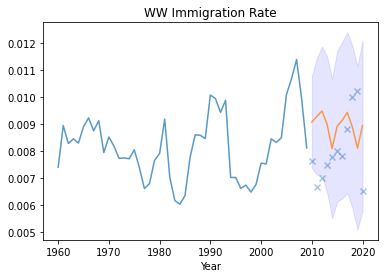

In [46]:
train_exog = train_exog_ww_logGDP
test_exog = test_exog_ww_logGDP
title = 'WW Immigration Rate'

# Based on the instantied time series, where the train and test sets came from.
preds, conf_int = ww_im_rate.predict(train_exog, test_exog, trace=False)
ww_im_rate.predict_plot(preds, conf_int, title=title)

##### _Markov Regression Regime Test_

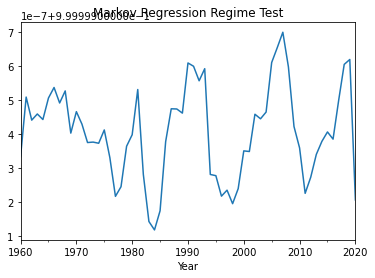

In [47]:
ww_im_rate_markov = ww_im_rate.test_markov_regime()

Immigration regime change plot is inconclusive.

If we were to remove 2022, Covid-19, Markov regression would be able to identify some spikes in the 1980s and 1990s. I wanted to preserve 2020 to see the effects on the rest of the data. It is very inconclusive in this view.

##### _Takeaways from ARMA Immigration Rates Worldwide_

>
> **Residuals:**
> - SARIMAX model order p, d, q, and seasonal P, D, Q, S (0, 1, 1) (0, 1, 0, 5).
> - *p* 0 indicatates there is no autocorrelation.
> - *d* 1 is low given that this is a stationary series.
> - *q* 1 is Moving Average order 1.
> - *P* 0 seasonal autocorrelation.
> - *D* 1 also low given this is stationary.
> - *Q* 0 seasonal Moving Average.
> - It was syuprisingly Moving Average order 1.
>
> **Markov Regression:**
> - This chart is inconclusive. All the states are in the middle.
>
> **Forecast on original series:**
> - The forecast underestimated the reduction in emigration (less negative).
> - The test data is within the 95% confidence intervals.

### _ARMA Net Emigration Worldwide_

#### _ARMA Before Decomposing: Net Emigration Worldwide_

##### _Instantiate TimeSeries object_

In [48]:
ww_net_em = TimeSeries(n_migr_gdp_df.N_NetEmigration, train_size=train_size)

##### _Plot histogram and Q-Q_

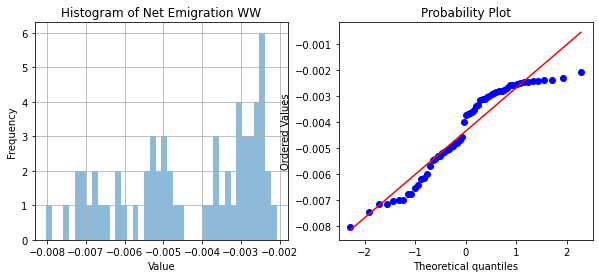

In [49]:
## OO method TimeSeries.plot_hist_qq
ww_net_em.plot_hist_qq('Net Emigration WW')

##### _Plot ACF and PACF_

lags =  20


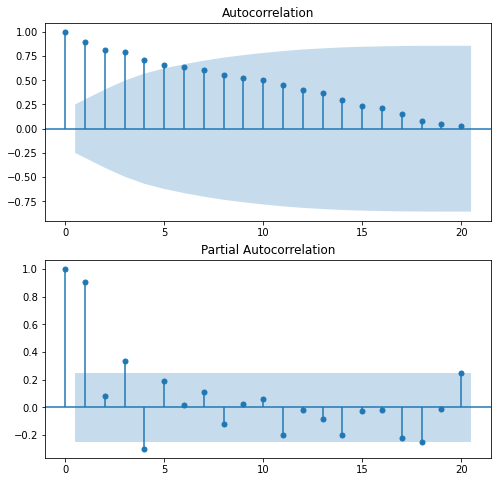

In [50]:
ww_net_em.acf_pacf_plots()

##### _ADF stationary test_

In [51]:
ww_net_em.test_ADF_stationary()

ADF test statistic = -1.4203304145433493
p-value = 0.5724915919310978
Critical Values:
	1%: -3.553
	5%: -2.915
	10%: -2.595
*** Time series is non-stationary.
*** Failed to reject the null hypothesis (H0). Either p-value > 0.05, or t-test 5% conf interval < test static.
Number of lags used = 4


{'test_stat': -1.4203304145433493,
 'p-value': 0.5724915919310978,
 'lags': 4,
 't-value_10%_conf': -2.595137155612245,
 't-value_5%_conf': -2.9147306250000002,
 't-value_1%_conf': -3.552928203580539}

##### _Histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q **S-shape** show that this is **not a Normal distribution.**
> - The time series is **non-stationary.**
> - The time series looks like a **random walk**.
> - The **ACF** has a very **slow decay**, but it eventually reaches zero.
> - While the **confidence intervals** of the ACF increase, they tend to become stable.
> - The PACF exhibits **correlation** in observation 1 (adjacent to zero).
> - The PACF appears to show **randomness**.

##### _Decompose the time series_

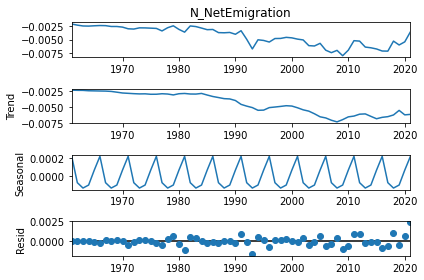

In [52]:
# Make period based on observation from decomposed residual (tested 20, 17*, 15, 10, 5 year periods)
decomp_ww_net_em = ww_net_em.decompose(extrapolate_trend='freq', period=5)

##### _Instantiate residuals object_

In [53]:
ww_net_em_res = TimeSeries(decomp_ww_net_em.resid)

##### _Plot residuals histogram and Q-Q_

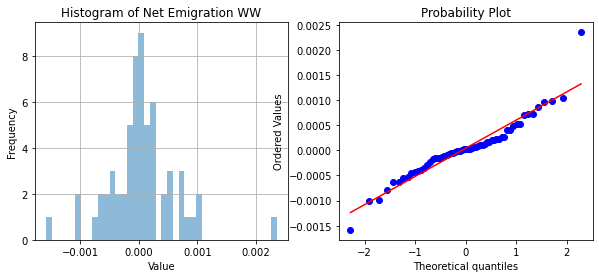

In [54]:
## OO method TimeSeries.plot_hist_qq
ww_net_em_res.plot_hist_qq('Net Emigration WW')

The outlier top-right is due to 2020 Covid-19. I left it in again to test the our process, handling such an outlier. 

##### _Plot residuals ACF and PACF_

lags =  20


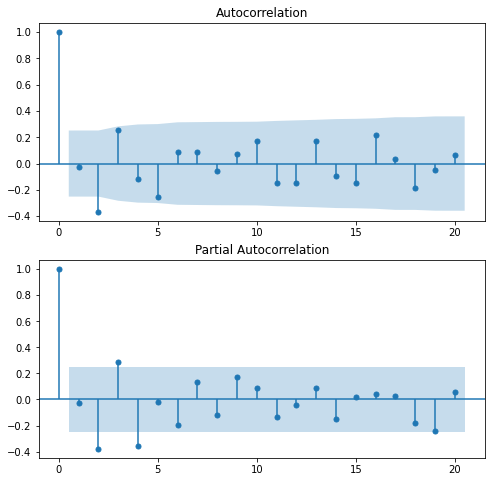

In [55]:
ww_net_em_res.acf_pacf_plots()

##### _Residuals ADF stationary test_

In [56]:
ww_net_em_res.test_ADF_stationary()

ADF test statistic = -3.1691967577297215
p-value = 0.021838372710839302
Critical Values:
	1%: -3.568
	5%: -2.921
	10%: -2.599
*** Time series is stationary.
*** Reject the null hypothesis (H0). Both p-value <= 0.05, and t-test 5% conf interval > test static.
Number of lags used = 10


{'test_stat': -3.1691967577297215,
 'p-value': 0.021838372710839302,
 'lags': 10,
 't-value_10%_conf': -2.5986616,
 't-value_5%_conf': -2.92135992,
 't-value_1%_conf': -3.568485864}

##### _Residuals histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q show **Normal distribution** characteristics. There is a distiguishable outlier (Covid-19, 2020).
> - The time series is **stationary.**
> - The time series looks could be **white noise**.
> - The **ACF** decays rapidly.
> - The ACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The ACT **confidence intervals** tend to become stable.
> - The PACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The PACF appears to be **periodical** or it may be **random**.

##### _Auto ARIMA residuals_

Apply the *auto_arima()* to the residual **stationary** model. Use an exogenous series on the auto_arima() model.

In [57]:
##
# BIC tests
#
# http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html
# https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

ww_net_em_res_best_model = ww_net_em_res.auto_arima(exogenous=exog_ww_st_logGDP, start_p=1, start_q=1, max_p=3, max_q=3, m=5,
                       start_P=0, seasonal=True, d=1, D=1, trace=True, 
                       information_criterion = 'bic', stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,1)[5]             : BIC=-602.451, Time=0.29 sec
 ARIMA(0,1,0)(0,1,0)[5]             : BIC=-581.683, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[5]             : BIC=-594.938, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[5]             : BIC=-610.145, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[5]             : BIC=-596.275, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[5]             : BIC=-603.218, Time=0.66 sec
 ARIMA(0,1,1)(0,1,2)[5]             : BIC=-600.913, Time=0.71 sec
 ARIMA(0,1,1)(1,1,0)[5]             : BIC=-607.830, Time=0.31 sec
 ARIMA(0,1,1)(1,1,2)[5]             : BIC=-599.553, Time=0.72 sec
 ARIMA(0,1,0)(0,1,1)[5]             : BIC=-595.378, Time=0.32 sec
 ARIMA(0,1,2)(0,1,1)[5]             : BIC=-587.367, Time=0.34 sec
 ARIMA(1,1,0)(0,1,1)[5]             : BIC=-597.793, Time=0.33 sec
 ARIMA(1,1,2)(0,1,1)[5]             : BIC=-620.597, Time=0.92 sec
 ARIMA(1,1,2)(0,1,0)[5]             : BIC=-606.480, Time=0.33 sec
 ARIMA(1,1,2)(1,1,1)[5]          

In [58]:
ww_net_em_res_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   61
Model:             SARIMAX(0, 1, 3)x(0, 1, [1], 5)   Log Likelihood                 325.132
Date:                             Fri, 23 Dec 2022   AIC                           -638.265
Time:                                     15:46:56   BIC                           -626.221
Sample:                                 12-31-1960   HQIC                          -633.607
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid          3.8888      1.421      2.736      0.006       1.103       6.674
ma.L1         -0.7155      0.159     -4.510      0.000      -1.026      -0.405
ma.L2         -0.4935      0.170     -2.910      0.004      -0.826      -0.161
ma.L3          0.4311      0.157      2.741      0.006       0.123       0.739
ma.S.L5       -0.6798      0.267     -2.547      0.011      -1.203      -0.157
sigma2       4.02e-07   8.32e-08      4.829      0.000    2.39e-07    5.65e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.33   Prob(JB):                         0.29
Heteroskedasticity (H):               5.66   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### _Predict with auto_arima()_

Apply simple *auto_arima()* on the original dataset to visualize predictions. It uses the original dataset instead of the residuals to visualize the original pattern. 

Test RMSE: 0.002


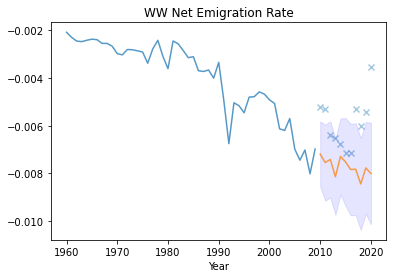

In [59]:
train_exog = train_exog_ww_logGDP
test_exog = test_exog_ww_logGDP
title = 'WW Net Emigration Rate'

# Based on the instantied time series, where the train and test sets came from.
preds, conf_int = ww_net_em.predict(train_exog, test_exog, trace=False)
ww_net_em.predict_plot(preds, conf_int, title=title)

##### _Markov Regression Regime Test_

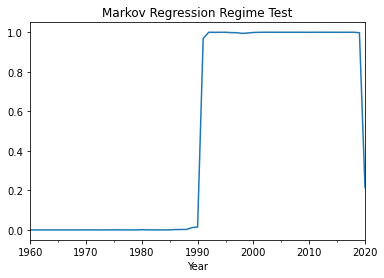

In [60]:
warnings.filterwarnings('ignore')
# This code was tested for warnings. Removed here for cleanliness.
ww_net_em_markov = ww_net_em.test_markov_regime()

##### _Takeaways from ARMA Emigration Rates Worldwide_

>
> **Residuals:**
> - SARIMAX model order p, d, q, and seasonal P, D, Q, S (0, 1, 1) (0, 1, 0, 5).
> - *p* 0 indicatates there is no autocorrelation.
> - *d* 1 is low given that this is a stationary series.
> - *q* 3 is Moving Average order 3, suprisongly large. We can see the lags outside the confidence interval.
> - *P* 0 seasonal autocorrelation.
> - *D* 1 also low given this is stationary.
> - *Q* 1 seasonal Moving Average.
> - It was syuprisingly Moving Average order 1.
>
> **Markov Regression:**
> - We see a big movement in the 1990s: **Globalization.*
> - The big emmigration events worldwide in the 1990s: 
> - The fall of the **Berlin Wall and China Tiananmem Square, authocratic governments losing power**.
>
> **Forecast on original series:**
> - The forecast tracked the first 4 years well, then it underestimated emigration decline (less negative).
> - Part of the test data is not within the 95% confidence intervals.

### _ARMA Net Immigration Worldwide_

#### _ARMA Before Decomposing: Net Immigration Worldwide_

##### _Instantiate TimeSeries object_

In [61]:
ww_net_im = TimeSeries(n_migr_gdp_df.N_NetImmigration, train_size=train_size)

##### _Plot histogram and Q-Q_

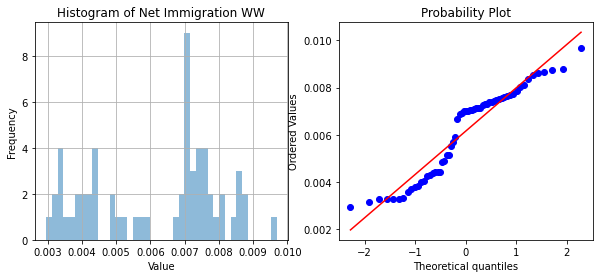

In [62]:
## OO method TimeSeries.plot_hist_qq
ww_net_im.plot_hist_qq('Net Immigration WW')

##### _Plot ACF and PACF_

lags =  20


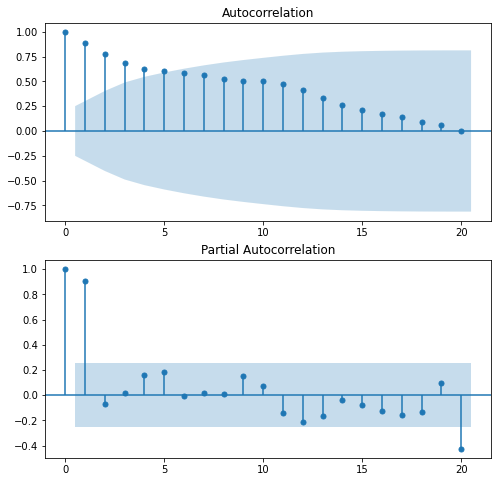

In [63]:
ww_net_im.acf_pacf_plots()

##### _ADF stationary test_

In [64]:
ww_net_im.test_ADF_stationary()

ADF test statistic = -2.1561653748718537
p-value = 0.22253760113710552
Critical Values:
	1%: -3.546
	5%: -2.912
	10%: -2.594
*** Time series is non-stationary.
*** Failed to reject the null hypothesis (H0). Either p-value > 0.05, or t-test 5% conf interval < test static.
Number of lags used = 1


{'test_stat': -2.1561653748718537,
 'p-value': 0.22253760113710552,
 'lags': 1,
 't-value_10%_conf': -2.5936515282964665,
 't-value_5%_conf': -2.911939409384601,
 't-value_1%_conf': -3.5463945337644063}

##### _Histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q **odd-shape** show that this is **not a Normal distribution.**
> - The time series is **non-stationary.**
> - The time series looks like a **random walk**.
> - The **ACF** has a very **slow decay**, but it eventually reaches zero.
> - While the **confidence intervals** of the ACF increase, they tend to become stable.
> - The PACF exhibits **correlation** in observation 1 (adjacent to zero).
> - The PACF appears to show **cycle** characteristics, resonating at around lag 20.

##### _Decompose the time series_

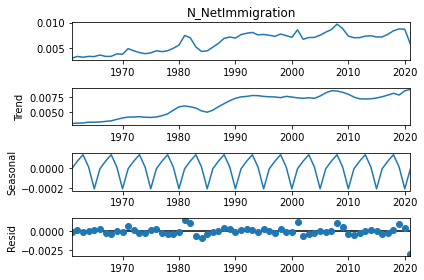

In [65]:
# Make period based on observation from decomposed residual (tested 20, 17*, 15, 10, 5 year periods)
decomp_ww_net_im = ww_net_im.decompose(extrapolate_trend='freq', period=5)

##### _Instantiate residuals object_

In [66]:
ww_net_im_res = TimeSeries(decomp_ww_net_im.resid)

##### _Plot residuals histogram and Q-Q_

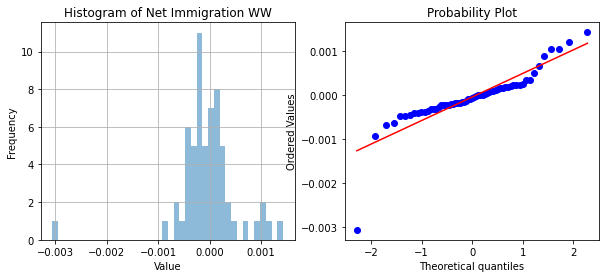

In [67]:
## OO method TimeSeries.plot_hist_qq
ww_net_im_res.plot_hist_qq('Net Immigration WW')

The outlier at the bottom comes from 2020, Covid-19.

##### _Plot residuals ACF and PACF_

lags =  20


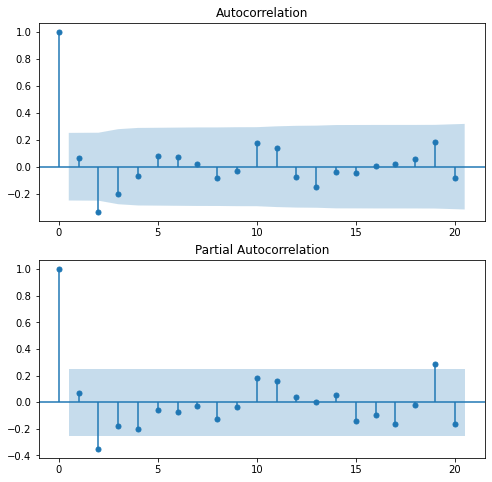

In [68]:
ww_net_im_res.acf_pacf_plots()

##### _Residuals ADF stationary test_

In [69]:
ww_net_im_res.test_ADF_stationary()

ADF test statistic = -5.573308034653251
p-value = 1.4509138721107626e-06
Critical Values:
	1%: -3.551
	5%: -2.914
	10%: -2.595
*** Time series is stationary.
*** Reject the null hypothesis (H0). Both p-value <= 0.05, and t-test 5% conf interval > test static.
Number of lags used = 3


{'test_stat': -5.573308034653251,
 'p-value': 1.4509138721107626e-06,
 'lags': 3,
 't-value_10%_conf': -2.5946240473991997,
 't-value_5%_conf': -2.913766394626147,
 't-value_1%_conf': -3.5506699942762414}

##### _Residuals histogram, Q-Q, ACF and PACF obeservation_

> - Histogram and Q-Q **S-shape** show **Normal distribution** characteristics. There is a distiguishable outlier (Covid-19, 2020).
> - The time series is **stationary.**
> - The time series looks could be **white noise**.
> - The **ACF** decays rapidly.
> - The ACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The ACT **confidence intervals** tend to become stable.
> - The PACF exhibits **no correlation** in observation 1 (adjacent to zero).
> - The PACF appears to be **periodical** or it may be **random**.

##### _Auto ARIMA residuals_

Apply the *auto_arima()* to the residual **stationary** model. Use an exogenous series on the auto_arima() model.

In [70]:
##
# BIC tests
#
# http://alkaline-ml.com/pmdarima/1.0.0/modules/generated/pmdarima.arima.auto_arima.html
# https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average

ww_net_im_res_best_model = ww_net_im_res.auto_arima(exogenous=exog_ww_st_logGDP, start_p=1, start_q=1, max_p=3, max_q=3, m=5,
                       start_P=0, seasonal=True, d=1, D=1, trace=True, 
                       information_criterion = 'bic', stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(1,1,1)(0,1,1)[5]             : BIC=-613.361, Time=0.28 sec
 ARIMA(0,1,0)(0,1,0)[5]             : BIC=-614.526, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[5]             : BIC=-623.481, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[5]             : BIC=-617.897, Time=0.36 sec
 ARIMA(1,1,0)(0,1,0)[5]             : BIC=-611.126, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[5]             : BIC=-620.146, Time=1.08 sec
 ARIMA(1,1,0)(1,1,1)[5]             : BIC=-617.340, Time=0.38 sec
 ARIMA(1,1,0)(0,1,1)[5]             : BIC=-617.396, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[5]             : BIC=-613.644, Time=0.92 sec
 ARIMA(0,1,0)(1,1,0)[5]             : BIC=-627.010, Time=0.17 sec
 ARIMA(0,1,0)(2,1,0)[5]             : BIC=-623.779, Time=0.18 sec
 ARIMA(0,1,0)(1,1,1)[5]             : BIC=-620.877, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[5]             : BIC=-620.960, Time=0.23 sec
 ARIMA(0,1,0)(2,1,1)[5]             : BIC=-617.137, Time=0.32 sec
 ARIMA(0,1,1)(1,1,0)[5]          

In [71]:
ww_net_im_res_best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   61
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 5)   Log Likelihood                 319.516
Date:                           Fri, 23 Dec 2022   AIC                           -633.032
Time:                                   15:47:10   BIC                           -627.010
Sample:                               12-31-1960   HQIC                          -630.703
                                    - 12-31-2020                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
resid          2.2416      1.357      1.652      0.098      -0.417       4.900
ar.S.L5       -0.6203      0.124     -4.986      0.000      -0.864      -0.376
sigma2      5.024e-07   7.91e-08      6.352      0.000    3.47e-07    6.57e-07
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):                40.79
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               3.19   Skew:                            -1.13
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### _Predict with auto_arima()_

Apply simple *auto_arima()* on the original dataset to visualize predictions. It uses the original dataset instead of the residuals to visualize the original pattern. 

Test RMSE: 0.001


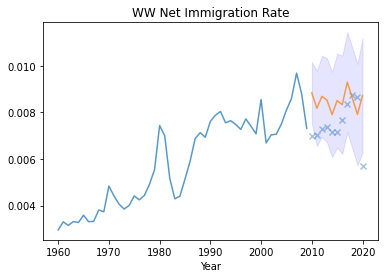

In [72]:
train_exog = train_exog_ww_logGDP
test_exog = test_exog_ww_logGDP
title = 'WW Net Immigration Rate'

# Based on the instantied time series, where the train and test sets came from.
preds, conf_int = ww_net_im.predict(train_exog, test_exog, trace=False)
ww_net_im.predict_plot(preds, conf_int, title=title)

##### _Markov Regression Regime Test_

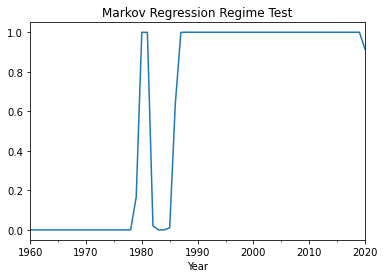

In [73]:
ww_net_im_markov = ww_net_im.test_markov_regime()

##### _Takeaways from ARMA Emigration Rates Worldwide_

>
> **Residuals:**
> - SARIMAX model order p, d, q, and seasonal P, D, Q, S (0, 1, 0) (1, 1, 0, 5).
> - *p* 0 indicatates there is no autocorrelation. Looks like **white noise**.
> - *d* 1 is low given that this is a stationary series.
> - *q* 0 is Moving Average order 3, suprisongly large.
> - *P* 1 seasonal autocorrelation.
> - *D* 1 also low given this is stationary.
> - *Q* 0 seasonal Moving Average.
> - It was syuprisingly Moving Average order 1.
>
> **Markov Regression:**
> - Capture changes overall before 1980 versus after 1980.
> - We see a large increase, trending with population growth likely.
>
> **Forecast on original series:**
> - The forecast tracked the test data really well.
> - The test data is not within the 95% confidence intervals.

### _Vector Normalized_

#### _Build DataFrame with Stationary Time Series_

In [74]:
# Build the DataFrame using dictionary
# st_migr_gdp_df = pd.DataFrame({'ST_EmigrationRate':decomp_ww_em_rate.resid, 'ST_ImmigrationRate':decomp_ww_im_rate.resid,
#                             'ST_NetEmigration':decomp_ww_net_em.resid, 'ST_NetImmigration':decomp_ww_net_im.resid,
#                             'ST_EmigrationGDPgrowth':gdp_b0, 'ST_ImmigrationGDPgrowth':gdp_b1,
#                             'ST_EmigrationLogGDP':log_gdp_b0, 'ST_ImmigrationLogGDP':decomp_ww_logGDP.resid,
#                             'ST_EmigrationPop':pop_b0, 'ST_ImmigrationPop':pop_b1,
#                             'ST_PopulationTot':mean_pop_tot}, index=n_migr_gdp_df.index )

# References 
1. United Nations Datamart (accessed Sep. 13, 2022) http://data.un.org/
1. United Nations Datamart (accessed Sep. 13, 2022) http://data.un.org/Explorer.aspx
1. United Nations Datamart - World Population Prospects (accessed Sep. 13, 2022) https://population.un.org/wpp/Download/Standard/MostUsed/
1. World Bank DataBank. Global Bilateral Migration (accessed Nov. 7, 2022) https://databank.worldbank.org/source/global-bilateral-migration/Type/TABLE/preview/on#
1. World Bank Leading https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?view=charthttps://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?view=chart
1. World Bank World Development Indicators (accessed Nov. 21, 2022) P_Data_Extract_From_World_Development_Indicators https://databank.worldbank.org/source/world-development-indicators
1. World Bank World GDP (accessed Nov. 23, 2022) https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG file API_NY.GDP.MKTP.KD.ZG_DS2_en_excel_v2_4701280.xls
1. United States Department of Home Land Security - (accessed Oct. 2, 2022) https://www.dhs.gov/immigration-statistics/naturalizations
1. United States Department of Home Land Security - U.S. Naturalizations 2021 Data Tables (accessed Oct. 2, 2022) https://www.dhs.gov/sites/default/files/2022-09/2022_0624_plcy_naturalizations_fy2021_tables.zip
1. United States Department of Home Land Security - Good background from: (accessed Oct. 2, 2022) https://www.dhs.gov/sites/default/files/2022-07/2022_0624_plcy_naturalizations_fy2021.pdf
1. United State Census Bureau. B05005 PERIOD OF ENTRY BY NATIVITY AND CITIZENSHIP STATUS IN THE UNITED STATES (accessed Oct. 2, 2022) https://data.census.gov/cedsci/table?q=mexican%20migration&tid=ACSDT5YSPT2015.B05005
1. United State Census Bureau. B05003 SEX BY AGE BY NATIVITY AND CITIZENSHIP STATUS (accessed Oct. 2, 2022) https://data.census.gov/cedsci/table?q=mexican%20migration&tid=ACSDT5YSPT2015.B05003
1. United State Census Bureau. S0502 SELECTED CHARACTERISTICS OF THE FOREIGN-BORN POPULATION BY PERIOD OF ENTRY (accessed Oct. 2, 2022) https://data.census.gov/cedsci/table?tid=ACSST1Y2021.S0502
1. United State Census Bureau. S0506 SELECTED CHARACTERISTICS OF THE FOREIGN-BORN POPULATION BY REGION OF BIRTH: LATIN AMERICA (accessed Oct. 2, 2022) https://data.census.gov/cedsci/table?tid=ACSST1Y2021.S0506
1. CONAPO (Mexican National Counsil of Population) - "Estimaciones del CONAPO con base en el INEGI, Censo de Población y Vivienda 2020 y 2000." (accessed Oct. 2, 2022) https://www.gob.mx/conapo
1. Gobierno de Mexico - Migración Mundial (accessed Oct. 6, 2022) https://datos.gob.mx/busca/dataset/migracion-mundial
1. Gobierno de Mexico - Instituto Nacional de Migracion (accessed Oct. 6, 2022) https://www.gob.mx/inm
1. Gobierno de Mexico - Índices de Intensidad Migratoria México-Estados Unidos (accessed Oct. 6, 2022) https://datos.gob.mx/busca/dataset/indices-de-intensidad-migratoria-mexico-estados-unidos
1. Gobierno de Mexico - Índice de Intensidad Migratoria a nivel estatal y municipal, 2000 (accessed Oct. 6, 2022) https://datos.gob.mx/busca/dataset/indices-de-intensidad-migratoria-mexico-estados-unidos/resource/7ee683ee-3833-4d01-8a28-5a01caa8f645
1. Gobierno de Mexico - Índice de Intensidad Migratoria a nivel estatal y municipal, 2020 (accessed Oct. 6, 2022) https://datos.gob.mx/busca/dataset/indices-de-intensidad-migratoria-mexico-estados-unidos/resource/cab3af23-85a4-41db-a2f0-8a99c1b0c850
1. Gobierno de Mexico - Migrantes recientes y no migrantes por grandes grupos de edad según entidad federativa, 1990 - 2010 (accessed Oct. 6, 2022) https://datos.gob.mx/busca/dataset/migracion-interna/resource/4e0b461a-1832-491b-8226-7f75e36a193e?inner_span=True
1. ION Global Migration Analysis Centre. Migration Data Portal (accessed Sep 14, 2013) https://www.migrationdataportal.org/ 
1. Norimitsu Onishi (2021, December 2). Migration Talking Points Surge in France, but Not Migration. The New York Times. Retrieved from https://www.nytimes.com/2021/12/02/world/europe/french-election-immigration.html
1. Carl Zimmer (2017, July 4). In Neanderthal DNA, Signs of Mysterious Human Migration. The New York Times. Retrieved from https://www.nytimes.com/2017/07/04/science/neanderthals-dna-homo-sapiens-human-evolution.html
1. Hervella, M., Svensson, E., Alberdi, A. et al. The mitogenome of a 35,000-year-old Homo sapiens from Europe supports a Palaeolithic back-migration to Africa. Sci Rep 6, 25501 (2016). https://doi.org/10.1038/srep25501
1. Jake VanderPlasJake VanderPlas. "Python Data Science HandbookPython Data Science Handbook" Released November 2016. Publisher(s): O'Reilly Media, Inc. ISBN: 9781491912058b. (chapters included https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html)
1. Stackoverflow community. (accessed Dec. 14, 2022) https://stackoverflow.com/
1. Geeks for Geeks. Python community. (accessed Dec. 12, 2022) https://www.geeksforgeeks.org/python-programming-language/
1. Pandas documentation. (accessed Sep. 20, 2022) https://pandas.pydata.org/docs/user_guide/index.html
1. "Pandas General Functions" (accessed Sep. 4, 2022) https://pandas.pydata.org/pandas-docs/stable/reference/general_functions.html
1. Seaborn documentation (accessed Sep. 12, 2022) https://seaborn.pydata.org/
1. matplotlib documentation (accessed Sep. 12, 2022) https://matplotlib.org/
1. NumPy documentation (accessed Sep. 12, 2022) https://numpy.org/
1. matplotlib documentation (accessed Sep. 12, 2022) https://matplotlib.org/
1. satsmodels documentation (accessed Dec. 14, 2022) https://statsmodels.org/
1. SciPy stats (accessed Sep. 20, 2022) https://docs.scipy.org/doc/scipy/reference/stats.html
1. Kaggle Time Series (access Dec. 14, 2022) https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacfhttps://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf
1. Alcaline-ML. "ARIMA estimators for Python" http://alkaline-ml.com/pmdarima/1.0.0/index.html
